<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Semantic_Segmentation_2_Class_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import numpy as np
import pandas as pd
import os 
import math
import random

from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout, Activation, MaxPool2D, concatenate
from keras.models import Model
from PIL import Image

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
mask_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/trimaps/'

In [ ]:
image_files = glob(image_dir + '*.jpg')
mask_files = glob(mask_dir + '*.png')

In [ ]:
images = []
masks = []

for image_file in image_files:
    mask_file = image_file.replace(image_dir, mask_dir).replace('.jpg', '.png')

    image = Image.open(image_file)
    image_mode = image.mode
    image = tf.image.resize(np.array(image), (224, 224))
    images.append(image)
    if image_mode != 'RGB':
        images.pop()
        continue

    if mask_file not in mask_files:
        images.pop()
    else:
        mask = Image.open(mask_file)
        mask = np.expand_dims(np.array(mask), -1)
        mask[mask != 1] = 0
        mask = tf.image.resize(mask, (224, 224))
        masks.append(mask)

images = np.array(images) / 255.
masks = np.array(masks) 

print(len(images), len(masks))

7378 7378


In [ ]:
train_size = int(len(images) * 0.9)
val_size = len(images) - train_size

train_batch_size = 16
val_batch_size = 16

dataset = tf.data.Dataset.from_tensor_slices((images, masks))

train_dataset = dataset.take(train_size)
val_dataset = dataset.take(val_size)

train_loader = train_dataset.batch(train_batch_size, drop_remainder=True).shuffle(1024)
val_loader = val_dataset.batch(val_batch_size, drop_remainder=True)

In [ ]:
for sample_batch in train_dataset:
    print(sample_batch[0])
    print(sample_batch[0].shape)
    break

tf.Tensor(
[[[0.74899083 0.67448103 0.6823242 ]
  [0.7683836  0.6989946  0.70513076]
  [0.7485595  0.6858144  0.68973595]
  ...
  [0.93569535 0.8814851  0.9217774 ]
  [0.93392617 0.8711811  0.9143183 ]
  [0.9084113  0.8624287  0.8888035 ]]

 [[0.75593114 0.68142134 0.6892645 ]
  [0.7630452  0.69365615 0.69979244]
  [0.74457157 0.6818265  0.68574804]
  ...
  [0.92742354 0.8732133  0.9118249 ]
  [0.90952647 0.8467814  0.88823795]
  [0.84654987 0.8005673  0.8266981 ]]

 [[0.7629352  0.6884254  0.69626856]
  [0.7498374  0.6804484  0.68658465]
  [0.7313125  0.6685674  0.672489  ]
  ...
  [0.91031957 0.8561093  0.8924801 ]
  [0.8639633  0.8012182  0.8404339 ]
  [0.80513924 0.75436735 0.7825677 ]]

 ...

 [[0.68362725 0.4119186  0.30155435]
  [0.6778187  0.40611002 0.29574576]
  [0.66404194 0.39233327 0.281969  ]
  ...
  [0.7713403  0.52428144 0.4654579 ]
  [0.7414331  0.4937415  0.43681616]
  [0.75104475 0.50094986 0.4368669 ]]

 [[0.661155   0.38216352 0.28244355]
  [0.6664493  0.38745788 0

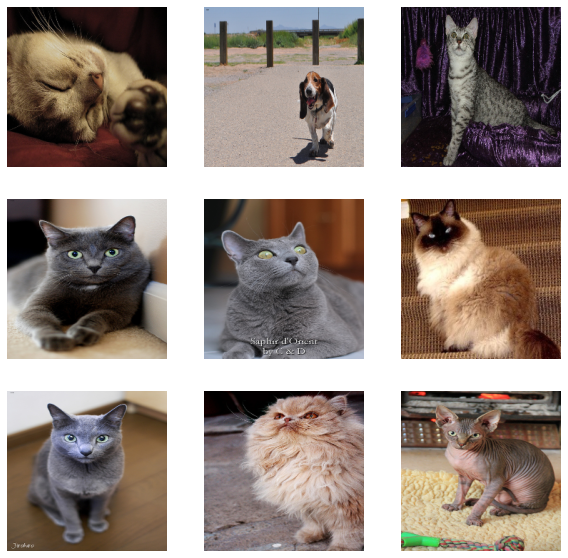

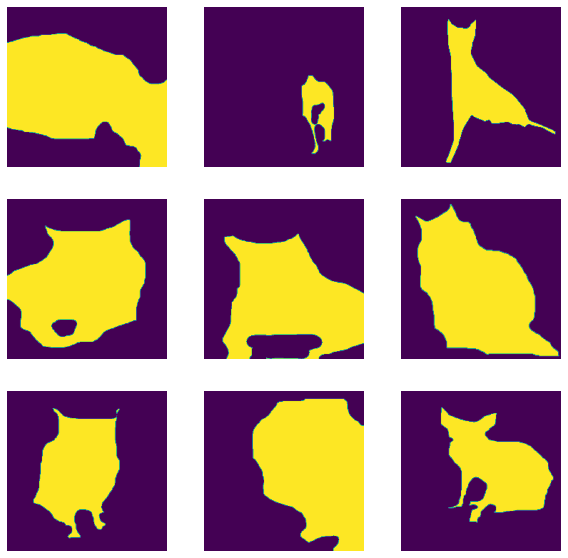

In [ ]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample[0][i])
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.reshape(sample[1][i], (224, 224)))
    plt.axis('off')
plt.show()

# Define UNet

In [ ]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet():
    inputs = Input((224, 224, 3))
    
    c1 = conv2d_block(inputs, 64)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.5)(p1)
    
    c2 = conv2d_block(p1, 128)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.5)(p2)
    
    c3 = conv2d_block(p2, 256)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.5)(p3)

    c4 = conv2d_block(p3, 512)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.5)(p4)

    c5 = conv2d_block(p4, 1024)
    
    u6 = Conv2DTranspose(512, 2, 2, output_padding=(0, 0))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.5)(u6)
    c6 = conv2d_block(u6, 512)
    
    u7 = Conv2DTranspose(256, 2, 2, output_padding=(0, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.5)(u7)
    c7 = conv2d_block(u7, 256)
    
    u8 = Conv2DTranspose(128, 2, 2, output_padding=(0, 0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.5)(u8)
    c8 = conv2d_block(u8, 128)
    
    u9 = Conv2DTranspose(64, 2, 2, output_padding=(0, 0))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.5)(u9)
    c9 = conv2d_block(u9, 64)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

# Define Iou & Dice Loss Function

In [ ]:
def iou(targets, preds):
    smooth = 1e-5

    preds = tf.reshape(preds, [-1])
    targets = tf.reshape(targets, [-1])

    intersection = tf.reduce_sum(preds * targets)
    union = tf.reduce_sum(preds) + tf.reduce_sum(targets) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def dice_coef(targets, preds):
    smooth = 1e-5

    preds = tf.reshape(preds, [-1])
    targets = tf.reshape(targets, [-1])

    intersection = tf.reduce_sum(preds * targets)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(preds) + tf.reduce_sum(targets) + smooth)
    return dice
    

def dice_loss(targets, preds):
    return 1 - dice_coef(targets, preds)

def bce_dice_loss(targets, preds):
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    loss = 1. * loss_fn(targets, preds) + 1. * dice_loss(targets, preds)

    return loss

# Define Model & Loss & Optimizer

In [ ]:
lr = 1e-2
epochs = 30

model = unet()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=bce_dice_loss, 
    metrics=[iou]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training

In [ ]:
hist = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=epochs
)

Epoch 1/30
415/415 [==============================] - 175s 379ms/step - loss: 0.9837 - iou: 0.3675 - val_loss: 1.1125 - val_iou: 0.4501
Epoch 2/30
415/415 [==============================] - 159s 376ms/step - loss: 0.7751 - iou: 0.4714 - val_loss: 1.2008 - val_iou: 0.3678
Epoch 3/30
415/415 [==============================] - 157s 374ms/step - loss: 0.6628 - iou: 0.5339 - val_loss: 0.7317 - val_iou: 0.6096
Epoch 4/30
415/415 [==============================] - 157s 374ms/step - loss: 0.6071 - iou: 0.5661 - val_loss: 0.6262 - val_iou: 0.5537
Epoch 5/30
415/415 [==============================] - 157s 374ms/step - loss: 0.5688 - iou: 0.5896 - val_loss: 0.6056 - val_iou: 0.6039
Epoch 6/30
415/415 [==============================] - 156s 373ms/step - loss: 0.5345 - iou: 0.6107 - val_loss: 0.7007 - val_iou: 0.5094
Epoch 7/30
415/415 [==============================] - 156s 373ms/step - loss: 0.4998 - iou: 0.6320 - val_loss: 0.5905 - val_iou: 0.6047
Epoch 8/30
415/415 [============================

# Visualization Loss & IOU

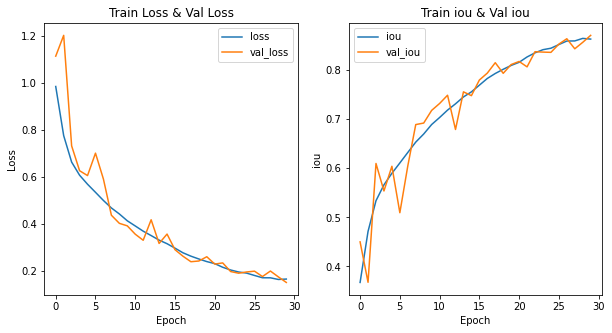

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Train Loss & Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(hist.history['iou'], label='iou')
plt.plot(hist.history['val_iou'], label='val_iou')
plt.legend(loc='best')
plt.title('Train iou & Val iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.show()

# Test Model

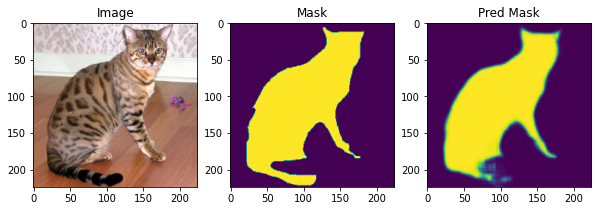

Iou:  0.8837915


In [ ]:
img , mask = next(iter(val_loader))
img, mask = img[0:1], mask[0]

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img[0])
plt.title('Image')
plt.subplot(132)
mask = np.reshape(mask, (224, 224))
plt.imshow(mask)
plt.title('Mask')

pred = model.predict(img)
pred = np.reshape(pred, (224, 224))
plt.subplot(133)
plt.imshow(pred)
plt.title('Pred Mask')
plt.show()

print('Iou: ', iou(pred, mask).numpy())